## Backtest analysis of funding gains of Binance perps at various leverage levels

Perpetual futures have a `funding rate` that is applied to user balances based on the deviation between the traded prices of the future product and the price of the target index (usually the prices on a spot exchange). The `funding rate` is used to tether the price of the future to the price of the target index. If the future's price tends to be above the price of the target index over the previous lookback period (usually defined as 8 hours), the `funding rate` is positive and longs pay shorts. If the price of the future tends to be below the price of the target index over the previous lookback period, the `funding rate` is negative and shorts pay longs.

For Binance and Bitmex, the `funding rate` defaults to a base rate (currently 0.01%; ~11% APR) if the average difference between the future's price and the index price is within a band (plus/minus 5 bp) around zero. Additionally, retail traders tend to be more bullish then bearish. The `funding rate` also tends to be decently correlated to market conditions (more positive in strong bullish markets and negative in bearish markets).

Hypothesis: A market neutral strategy of shorting (potentially with leverage) perpetual futures and hedging by going long in the spot, leveraged token, or dated futures market will outperform on a risk-adjusted basis, particularly if the underlying crypto market turns stronly bullish.


### Analysis Goals

* Backtest net returns over the various Binance perpetual swap futures products, assuming variable amounts of leverage and trade sizes
* Backtest/analyze the "safety" of a position, at various levels of leverage, across various market conditions. Forced liquidation should be strongly avoided.
* Analyze funding rate outliers and understand how consistent the funding rate trends are. For example, does an alt perp trading pair's funding rate typically stay elevated above 0.01% for more than 1 funding period? 2? 3?
* Understand how frequent the funding rates flip between positive and negative so we can analyze trade volume for both futures and spot hedging. The less frequent we trade, the more pnl, but less volume we are driving to synths via hedging.

In [1]:
# Imports - Initialization
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
import datetime
import utils.fetchBars_sql as fetchBars

### Backtest1

Assume a simple strategy of shorting the Binance perpetual contract using leverage, L, and hedging by going long the spot market. 

**Parameters**

| parameter | description |
| :--- | :--- |
| L | leverage  |
| P | portion of capital devoted to margin on Binance |
| S | portion of capital needed to hedge via spot market (no leverage) |





In [2]:
#
# PARAMETERS
# 
SYMBOL = "ETHUSDT"

#Set the dates to customize anlaysis period
STARTDATE = datetime.datetime(2019,1,1)
ENDDATE = datetime.datetime.now()

In [3]:
# 
# Capital Allocations for various Leverage Values
#

# spot_capital + margin_mapital * leverage should equal total capital.
# Constraining Equations: S + L*P = 1; and S = L*P

vs = []
for l in [1,2,3,4,5,6]:
    F = 1/(l+1)
    S = 1 - F
    vs.append({"L":l , "S":S, "F":F})
_df = pd.DataFrame(vs)
_df = _df.set_index('L')
df_capital_allocation = _df.sort_index()

In [4]:
print("Table showing portion of total capital allocated to spot long position (S) and future margin (F):")
print(df_capital_allocation)

Table showing portion of total capital allocated to spot long position (S) and future margin (F):
          S         F
L                    
1  0.500000  0.500000
2  0.666667  0.333333
3  0.750000  0.250000
4  0.800000  0.200000
5  0.833333  0.166667
6  0.857143  0.142857


In [5]:
#
# Read in symbol bar and funding data
#

print("Reading data for", SYMBOL, " ...")
d = fetchBars.readBarsDB(SYMBOL, "binance", STARTDATE.timestamp(), ENDDATE.timestamp()) #Returns dictof (ts, o, h, l, c, v) tuples, indexed by ts
bars_dict = {pd.Timestamp(ts, unit = "s"): {'ts': pd.Timestamp(ts, unit = "s"), 'c':c} for ts, o, h, l, c, v in d.values()}

keys = list(bars_dict.keys())
#Funding Rates
_df_F = fetchBars.fetchFundingData(SYMBOL, 'binance', startTS = datetime.datetime(2018,1,1))
_df_F = _df_F.loc[~_df_F.index.duplicated(keep='first')]
values = []
for ts, f_rate in zip(_df_F.index, _df_F['fund_rate'].values):
    if ts.tz_convert(None) in bars_dict:
        o = bars_dict[ts.tz_convert(None)]
        o.update({'fund_rate': f_rate})
        values.append(o)
_df = pd.DataFrame(values)
_df = _df.set_index('ts')
_df = _df.dropna()
df_price_8h = _df.sort_index()  

#create 1_min dataframe value with funding
for index, row in _df_F.iterrows():
    ts = index.tz_convert(None)
    if ts in bars_dict:
        bars_dict[ts].update({'fund_rate': row['fund_rate']})
    else:
        print("error.", ts, " not in bars_dict")
df_1m = pd.DataFrame(bars_dict.values())
df_1m = df_1m.set_index('ts')
df_1m = df_1m.sort_index()
df_1m = df_1m.fillna(0)

print("Done Reading.")


Reading data for ETHUSDT  ...
Done Reading.


#### Plot of cumulative funding v. Price

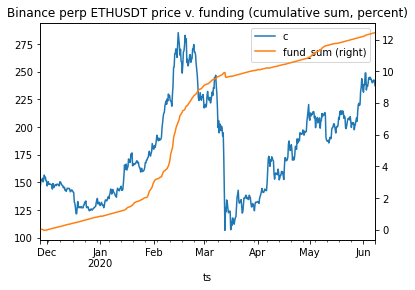

In [6]:
df_price_8h['fund_sum'] = df_price_8h['fund_rate']*100
df_price_8h['fund_sum'] = df_price_8h['fund_sum'].cumsum()

title = 'Binance perp ' + SYMBOL + ' price v. funding (cumulative sum, percent)'
df_price_8h.loc[:, ['c', 'fund_sum']].plot(secondary_y = ['fund_sum'], title = title)

#### Cumulative perp return with leverage

Plot the cumulative return on capital, factoring in leverage. Leverage is also plotted, as leverage changes based on unrealized gains. The formula for cumulative return, factoring in leverage, is: (cumulative_funding_return / 2) * L.

In [20]:
INITIAL_TOTAL_CAPITAL = 10000

#maintenance margin (mm) rate (%). Binance mm is based on position size and varies widely.
MAINTENANCE_MARGIN_RATE = 5.0  

L = 3    #Target leverage to use on futures exchange


Binance Maintenance Margins:

![binance_mm](binance_mm.png "Binance maintentance margin levels")

In [21]:
# fut_Ks       number of future contracts
# fut_unreal   unrealized gains in the futures account
# fut_lev      leverage at the particular sample
# fut_account  the account value of the futures account: initial_capital + unrealized_gains + funding_cum
# funding_credit applied funding credit; applied every 8 hours. 

# port_gain    portfolio gain. Funding sum divided by initial capital.

f = 1 / (L+1)
max_leverage = 100 / MAINTENANCE_MARGIN_RATE
initial_entry_price = df_1m.iloc[0]['c']
initial_fut_capital = INITIAL_TOTAL_CAPITAL * f

df_1m['fut_Ks'] = -1 * (L * initial_fut_capital) / initial_entry_price
df_1m['fut_unreal'] = df_1m['fut_Ks'] * (df_1m['c'] - initial_entry_price)
df_1m['funding_credit'] = df_1m['fund_rate'] * df_1m['fut_Ks'] * df_1m['c'] * -1
df_1m['fut_account'] = initial_fut_capital +  df_1m['fut_unreal'] + df_1m['funding_credit'].cumsum()
df_1m['fut_lev'] = abs((df_1m['fut_Ks'] * df_1m['c']) / df_1m['fut_account'])
df_1m['port_gain'] = df_1m['funding_credit'].cumsum() / INITIAL_TOTAL_CAPITAL * 100


Max Leverage Before Liquidation: 20.0
Initial Position Entry Price: 146.0
Initial Deployed Capital - Futures: 2500.0
Initial Deployed Capital - Spot: 7500.0
Initial (target) Leverage: 3


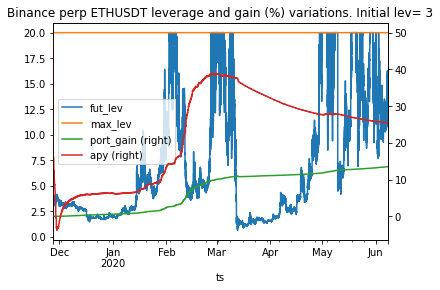

In [22]:
# Plot some key stats
print("Max Leverage Before Liquidation:", max_leverage)
print("Initial Position Entry Price:", initial_entry_price)
print("Initial Deployed Capital - Futures:", initial_fut_capital)
print("Initial Deployed Capital - Spot:", INITIAL_TOTAL_CAPITAL - initial_fut_capital)
print("Initial (target) Leverage:", L)

df_1m['max_lev'] = max_leverage
df_1m['fut_lev'] = df_1m['fut_lev'].clip(0, max_leverage)
start_time = df_1m.index[0]
df_1m['apy'] = 365/((df_1m.index - start_time).total_seconds() / (60*60*24)) *df_1m['port_gain']
df_1m['apy'] = df_1m['apy'].clip(-30, 50)


title = 'Binance perp ' + SYMBOL + ' leverage and gain (%) variations. Initial lev= ' + str(L)
df_1m.loc[:, ['fut_lev', 'max_lev', 'port_gain', 'apy']].plot(secondary_y = ['port_gain', 'apy'], title = title)

#df_price_8h.loc[:, ['c', 'fund_sum']].plot(secondary_y = ['fund_sum'], title = title)



In [23]:
df_1m['apy'].max()

50.0